# Reuters: Classifying Newswires

In this chapter, we’ll build a model to classify Reuters newswires into 46 mutually exclusive topics. Because we have many classes, this problem is an instance of multiclass classification, and because each data point should be classified into only one category, the problem is more specifically an instance of single-label multiclass classification. If each data point could belong to multiple categories (in this case, topics), we’d be facing a multilabel multiclass classification problem.

## Reading-In the Data

You’ll work with the Reuters dataset, a set of short newswires and their topics, published by Reuters in 1986. It’s a simple, widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

The Reuters dataset comes packaged as part of Keras. Let’s take a look.

In [ ]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

2023-11-07 14:06:34.508338: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 14:06:34.549000: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 14:06:34.549027: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 14:06:34.549062: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 14:06:34.556803: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 14:06:34.557185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

There are 8,982 training examples and 2,246 test examples.

In [ ]:
len(train_data)

8982

In [ ]:
len(test_data)

2246

Each example is a list of integers (word indices).

In [ ]:
print(train_data[10])

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


Here’s how you can decode it back to words.

In [ ]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = " ".join([reverse_word_index.get(i - 3, "?") for i in
    train_data[0]])

In [ ]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with an example is an integer between 0 and 45—a topic index.

In [ ]:
train_labels[10]

3

## Data Wrangling

The data requires a bit of wrangling before it can be fed into a neural network.  Let's begin by vectorizing the newswires.  Notice that we are flattening our sequential data, and hence removing any sense of ordering from it.

In [ ]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [ ]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

To vectorize the labels, there are two possibilities: you can cast the label list as an integer tensor, or you can use one-hot encoding. One-hot encoding is a widely used format for categorical data, also called categorical encoding. In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index.  We will use one-hot encoding.

In [ ]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)

Note that there is a built-in convenience function in **keras** for doing this.

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

In [ ]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Building the Model

We will use a dense feed forward network, using `keras.Sequential`, with two hidden layers each consisting of 64 units (a bit larger than we used for the IMBD dataset).  The hidden layers will both have a `relu` activation function.  The output layer will have 46 units, corresponding to the different possible topics.  We will use a `softmax` activation function so that the output is probabilities.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

Next, let's move on to the compilation step.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels. By minimizing the distance between these two distributions, you train the model to output something as close as possible to the true labels.

In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## Creating a Validation Set

Let’s set apart 1,000 samples in the training data to use as a validation set.

In [ ]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = y_train[:1000]
partial_y_train = y_train[1000:]

## Train the Model

Now, let’s train the model for 20 epochs.

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 31ms/step - loss: 2.7817 - accuracy: 0.4762 - val_loss: 1.8855 - val_accuracy: 0.6200
Epoch 2/20
16/16 [==============================] - 0s 18ms/step - loss: 1.5537 - accuracy: 0.6790 - val_loss: 1.3791 - val_accuracy: 0.6950
Epoch 3/20
16/16 [==============================] - 0s 18ms/step - loss: 1.1681 - accuracy: 0.7497 - val_loss: 1.2099 - val_accuracy: 0.7250
Epoch 4/20
16/16 [==============================] - 0s 19ms/step - loss: 0.9574 - accuracy: 0.7937 - val_loss: 1.0892 - val_accuracy: 0.7680
Epoch 5/20
16/16 [==============================] - 0s 19ms/step - loss: 0.7947 - accuracy: 0.8311 - val_loss: 1.0249 - val_accuracy: 0.7860
Epoch 6/20
16/16 [==============================] - 0s 19ms/step - loss: 0.6663 - accuracy: 0.8586 - val_loss: 0.9733 - val_accuracy: 0.7850
Epoch 7/20
16/16 [==============================] - 0s 18ms/step - loss: 0.5599 - accuracy: 0.8812 - val_loss: 0.9353 - val_accuracy: 0.8030
Epoch 8/20
16

## Plotting Loss and Accuracy

Next, let's plot the loss and accuracy curves.

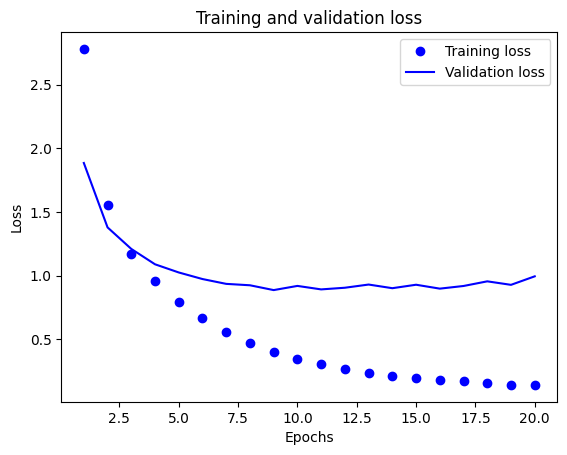

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

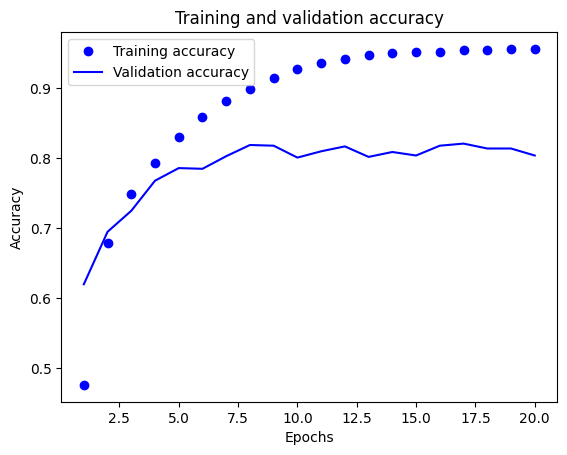

In [ ]:
plt.clf()
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Retraing the Model for Nine Epochs

As we can see in the above two plots.  The model begins to overfit after nine epochs. Let’s train a new model from scratch, on the entire training data set, for nine epochs and then evaluate it on the test set.

In [ ]:
model = keras.Sequential([
  layers.Dense(64, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(x_train,
          y_train,
          epochs=9,
          batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/9
18/18 [==============================] - 1s 15ms/step - loss: 2.6433 - accuracy: 0.5213
Epoch 2/9
18/18 [==============================] - 0s 15ms/step - loss: 1.4630 - accuracy: 0.6888
Epoch 3/9
18/18 [==============================] - 0s 17ms/step - loss: 1.1098 - accuracy: 0.7630
Epoch 4/9
18/18 [==============================] - 0s 15ms/step - loss: 0.8990 - accuracy: 0.8071
Epoch 5/9
18/18 [==============================] - 0s 15ms/step - loss: 0.7384 - accuracy: 0.8383
Epoch 6/9
18/18 [==============================] - 0s 16ms/step - loss: 0.6143 - accuracy: 0.8671
Epoch 7/9
18/18 [==============================] - 0s 14ms/step - loss: 0.5098 - accuracy: 0.8938
Epoch 8/9
18/18 [==============================] - 0s 16ms/step - loss: 0.4276 - accuracy: 0.9090
Epoch 9/9
71/71 [==============================] - 0s 2ms/step - loss: 0.9088 - accuracy: 0.7903


In [ ]:
results

[0.9087575674057007, 0.7902938723564148]

This approach reaches an accuracy of ~80%. With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%. But in this case, we have 46 classes, and they may not be equally represented. What would be the accuracy of a random baseline? We could try quickly implementing one to check this empirically.

In [ ]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
hits_array.mean()

0.18744434550311664

As you can see, a random classifier would score around 19% classification accuracy, so
the results of our model seem pretty good in that light.

## Predictions on New Data

Calling the model’s predict method on new samples returns a class probability distribution over all 46 topics for each sample. Let’s generate topic predictions for all of the test data.

In [ ]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


Each entry in `predictions` is a vector of length 46:

In [ ]:
predictions[0].shape

(46,)

The coefficients in this vector sum to 1, as they form a probability distribution:

In [ ]:
np.sum(predictions[0])

0.9999999

The largest entry is the predicted class — the class with the highest probability:

In [ ]:
np.argmax(predictions[0])

3

## Information Bottleneck

Now let’s see what happens when we introduce an information bottleneck by having intermediate layers that are
significantly less than 46-dimensions: for example, 4-dimensional.

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="relu"),
    layers.Dense(46, activation="softmax")
])
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 3.4442 - accuracy: 0.0804 - val_loss: 3.0439 - val_accuracy: 0.0920
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 2.4024 - accuracy: 0.4327 - val_loss: 1.9069 - val_accuracy: 0.6190
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 1.5456 - accuracy: 0.6437 - val_loss: 1.5021 - val_accuracy: 0.6490
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 1.2814 - accuracy: 0.6862 - val_loss: 1.3921 - val_accuracy: 0.6800
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 1.1347 - accuracy: 0.7256 - val_loss: 1.3320 - val_accuracy: 0.6900
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 1.0300 - accuracy: 0.7399 - val_loss: 1.3126 - val_accuracy: 0.6910
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 0.9475 - accuracy: 0.7546 - val_loss: 1.3068 - val_accuracy: 0.6970
Epoch 8/20
63/63 [=

<keras.src.callbacks.History>

In [ ]:
results = model.evaluate(x_test, y_test)
results

71/71 [==============================] - 0s 2ms/step - loss: 1.7752 - accuracy: 0.6941


[1.77518892288208, 0.6941229104995728]

The model now peaks at ~71% validation accuracy, an 8% absolute drop. This drop is mostly due to the fact that we’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The model is able to cram most of the necessary information into these four-dimensional representations, but not all of it.

## Further Exploration

Try out the following experiments to train your intuition about the kind of configuration decisions you have to make with such models:

- Try using larger or smaller layers: 32 units, 128 units, and so on.
- You used two intermediate layers before the final softmax classification layer. Now try using a single intermediate layer, or three intermediate layers.